# Ensemble with Kaggle Google Play Store dataset

@hyyoka

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

plt.style.use('ggplot') 
plt.rc('axes', unicode_minus=False)

# 1. 데이터 전처리 및 EDA

In [ ]:
train_data = pd.read_csv("/content/ggstore_train.csv")
test_data = pd.read_csv("/content/ggstore_test.csv")

In [ ]:
train_data.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Id
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,Art & Design,2018-01-07,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,1
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,Art & Design,2018-08-01,2


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5616 entries, 0 to 5615
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             5616 non-null   object 
 1   Category        5616 non-null   object 
 2   Rating          5616 non-null   float64
 3   Reviews         5616 non-null   int64  
 4   Size            5616 non-null   float64
 5   Installs        5616 non-null   float64
 6   Type            5616 non-null   int64  
 7   Price           5616 non-null   float64
 8   Content Rating  5616 non-null   object 
 9   Genres          5616 non-null   object 
 10  Last Updated    5616 non-null   object 
 11  Id              5616 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 526.6+ KB


## 1-1. 결측치 처리

In [ ]:
train_data.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Id                0
dtype: int64

Null값에 대한 Data cleaning은 이미 다 된 것으로 보이나, null값이 아니지만 무의미한 데이터가 있는지 체크하고, 앞으로의 전처리 전략을 세우기 위해 전체 columns의 unique한 변수들을 출력했다. 

In [ ]:
for c in list(train_data.columns): 
    print(c, train_data[c].unique())

App ['Photo Editor & Candy Camera & Grid & ScrapBook' 'Coloring book moana'
 'U Launcher Lite – FREE Live Cool Themes, Hide Apps' ...
 'Dr Dre - Beatmaker' "Dr. Cares - Amy's Pet Clinic 🐈 🐕"
 'Dr. Splorchy Presents Space Heroes']
Category ['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION']
Rating [4.1 3.9 4.7 4.5 4.3 4.4 3.8 4.2 4.6 4.  4.8 4.9 3.6 3.7 3.2 3.3 3.4 3.5
 3.1 5.  2.6 3.  1.9 2.5 2.8 2.7 1.  2.9 2.3 2.2 1.7 2.  1.8 2.4 1.6 2.1
 1.4 1.5]
Reviews [  159   967 87510 ... 97209  4518  3580]
Size [1.90e+01 1.40e+01 8.70e+00 2.50e+01 2.80e+00 5.60e+00 2.90e+01 3.30e+01
 3.1

## 1-2. 데이터 전처리


#### 1) Numericals

In [ ]:
# 1. Id 날리기
train_data = train_data.drop('Id', axis=1)
test_data = test_data.drop('Id', axis=1)

In [ ]:
# 2. last updated에서 year만 남기기
train_data['Last Updated'] = pd.to_datetime(train_data['Last Updated'])
train_data['year'] =train_data['Last Updated'].dt.year
train_data = train_data.drop('Last Updated', axis=1)

test_data['Last Updated'] = pd.to_datetime(test_data['Last Updated'])
test_data['year'] =test_data['Last Updated'].dt.year
test_data = test_data.drop('Last Updated', axis=1)

In [ ]:
#numeric 
n_train=train_data.select_dtypes(exclude='object')
#categorical 
c_train=train_data.select_dtypes(include='object')

In [ ]:
print(n_train.columns)
print(c_train.columns)

Index(['Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'year'], dtype='object')
Index(['App', 'Category', 'Content Rating', 'Genres'], dtype='object')


In [ ]:
# 3. outlier들 제거
def outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)
        modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

Text(0.5, 0.98, 'outlier')

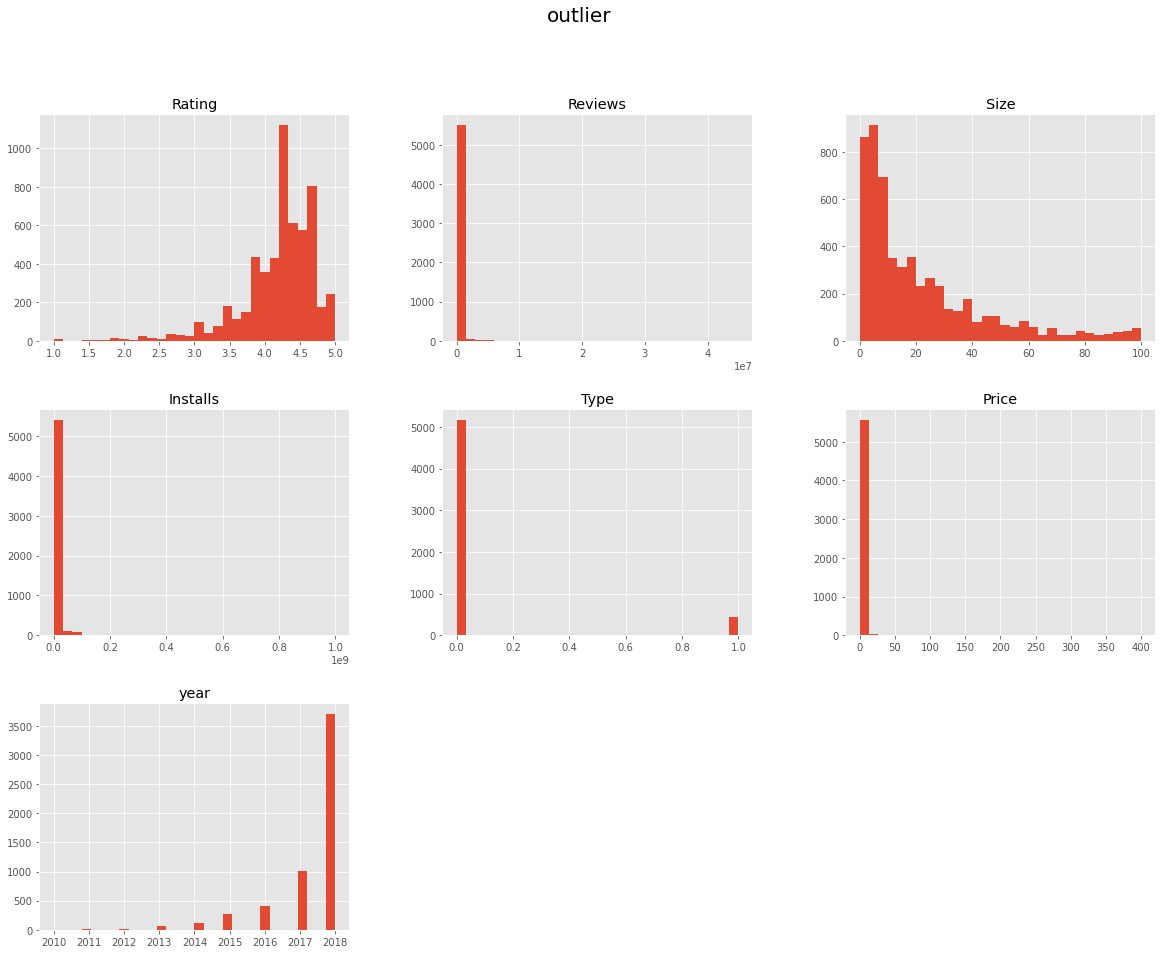

In [ ]:
n_train.hist(bins=30, figsize=(20,15))
plt.suptitle("outlier", fontsize=20)

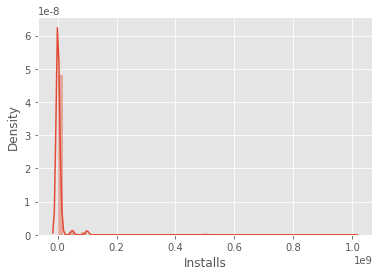

In [ ]:
new_train=train_data[~outlier(train_data.Installs)]
sns.distplot(train_data.Installs, kde=True, hist=True)

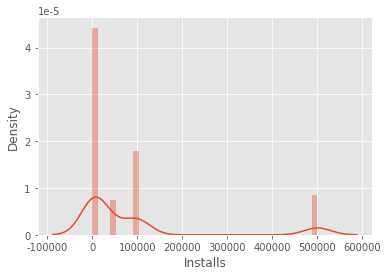

In [ ]:
#이상치 제거후 Installs의 변화
sns.distplot(new_train.Installs, kde=True, hist=True)

#### 2) Categorical

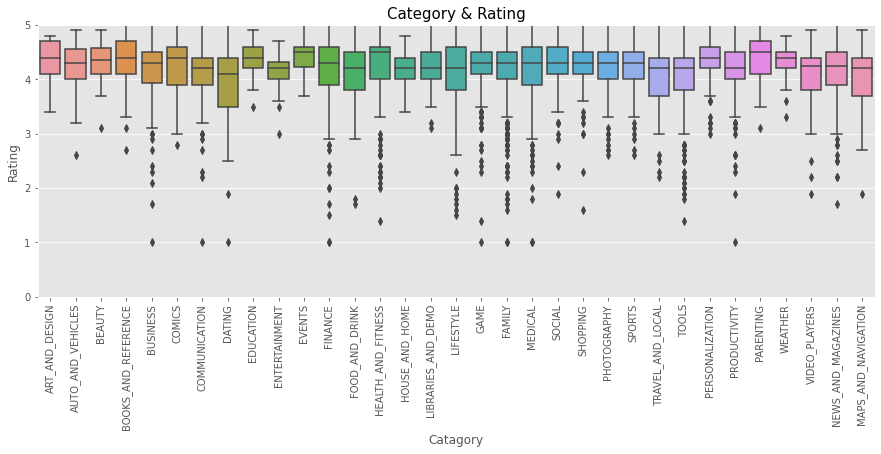

In [ ]:
# 1. Category와 rating간 관련성 파악

plt.figure(figsize=(15,5))
sns.boxplot(x='Category',y='Rating',data=train_data)
plt.xticks(rotation=90)
plt.title('Category & Rating',fontsize=15)
plt.xlabel('Catagory',fontsize=12)
plt.ylabel('Rating',fontsize=12)
plt.ylim(0,5)
plt.show()

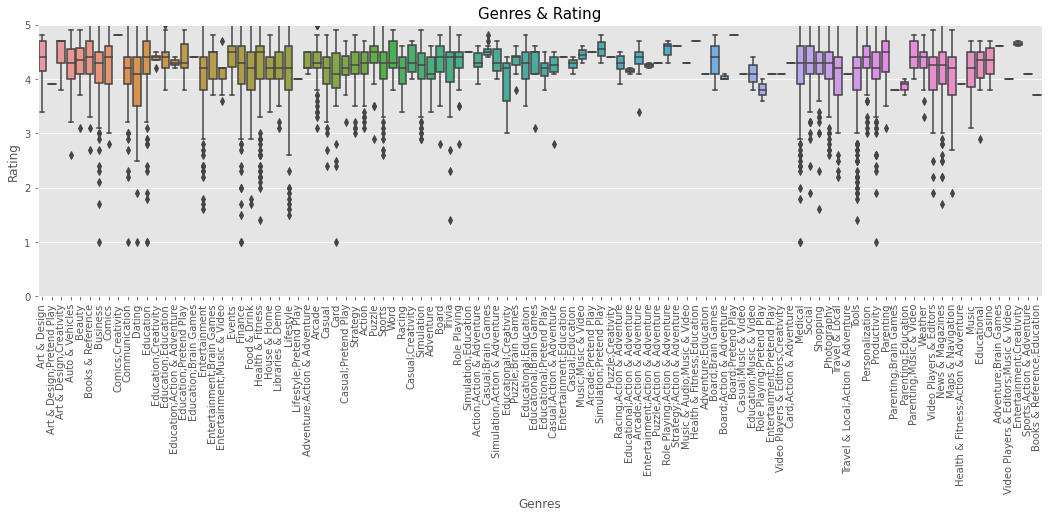

In [ ]:
# 2. Genre와 rating간 관련성 파악

plt.figure(figsize=(18,5))
sns.boxplot(x='Genres',y='Rating',data=train_data)
plt.xticks(rotation=90)
plt.title('Genres & Rating',fontsize=15)
plt.xlabel('Genres',fontsize=12)
plt.ylabel('Rating',fontsize=12)
plt.ylim(0,5)
plt.show()

In [ ]:
# 3. App과 rating간 관련성 파악

# plt.figure(figsize=(50,5))
# sns.barplot(x='App',y='Rating',data=train_data)
# plt.xticks(rotation=90)
# plt.title('App & Rating',fontsize=15)
# plt.xlabel('App',fontsize=12)
# plt.ylabel('Rating',fontsize=12)
# plt.ylim(0,5)
# plt.show()

생각해보았을 때, App 데이터는 rating에 있어서 굉장히 중요한 요소일 것이다. 사람들이 특정 어플리케이션에 느끼는 바는 평균적으로 유사하기 때문이다. 문제는 app의 종류가 너무 방대하다는 것이다. 그러나, 그래프에서도 rating과 app의 중요성이 강조되었으로, 더미변수화한다.

In [ ]:
# 4. Categorical들의 더미변수화

d_train=pd.get_dummies(c_train)
train_data=pd.concat([n_train,d_train], axis=1)

## 1-3. 다중공선성 

변수들간 독립성을 보장하기 위해, 다중공선성을 체크했다.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = n_train.copy()
X = X.drop('Rating', axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
5,2.027275,year
1,2.004479,Size
0,1.615629,Reviews
2,1.595465,Installs
3,1.152974,Type
4,1.065517,Price


독립성에는 문제가 없음을 확인했다. 

## 1-4. Correlation

In [ ]:
#정리된 변수들의 corr 다시 정리하여 상관도가 낮은 변수는 삭제한다.
cor_matrix=train_data.corr()

In [ ]:
corr=abs(cor_matrix['Rating']).sort_values(ascending=False)

# 상관 계수가  0.05 보다 작은  feature 삭제
low_corr=corr[corr<=0.05].index
X = train_data.drop(list(low_corr),axis=1)

In [ ]:
print(corr)

Rating                                1.000000
year                                  0.119213
Genres_Tools                          0.082526
Category_TOOLS                        0.082526
Size                                  0.081448
                                        ...   
App_Monster Truck Stunt 3D 2019       0.000556
App_Pink Silver Bow Keyboard Theme    0.000556
App_Tattoo Name On My Photo Editor    0.000556
Genres_Educational;Pretend Play       0.000388
Category_SPORTS                       0.000278
Name: Rating, Length: 5768, dtype: float64


In [ ]:
print(X)
print(train_data)

      Rating  Reviews  ...  Genres_Personalization  Genres_Tools
0        4.1      159  ...                       0             0
1        3.9      967  ...                       0             0
2        4.7    87510  ...                       0             0
3        4.5   215644  ...                       0             0
4        4.3      967  ...                       0             0
...      ...      ...  ...                     ...           ...
5611     4.1    97209  ...                       0             0
5612     4.0     4518  ...                       0             0
5613     4.3      146  ...                       0             0
5614     4.5     3580  ...                       0             0
5615     4.6       18  ...                       0             0

[5616 rows x 65 columns]
      Rating  Reviews  ...  Genres_Weather  Genres_Word
0        4.1      159  ...               0            0
1        3.9      967  ...               0            0
2        4.7    87510  ...

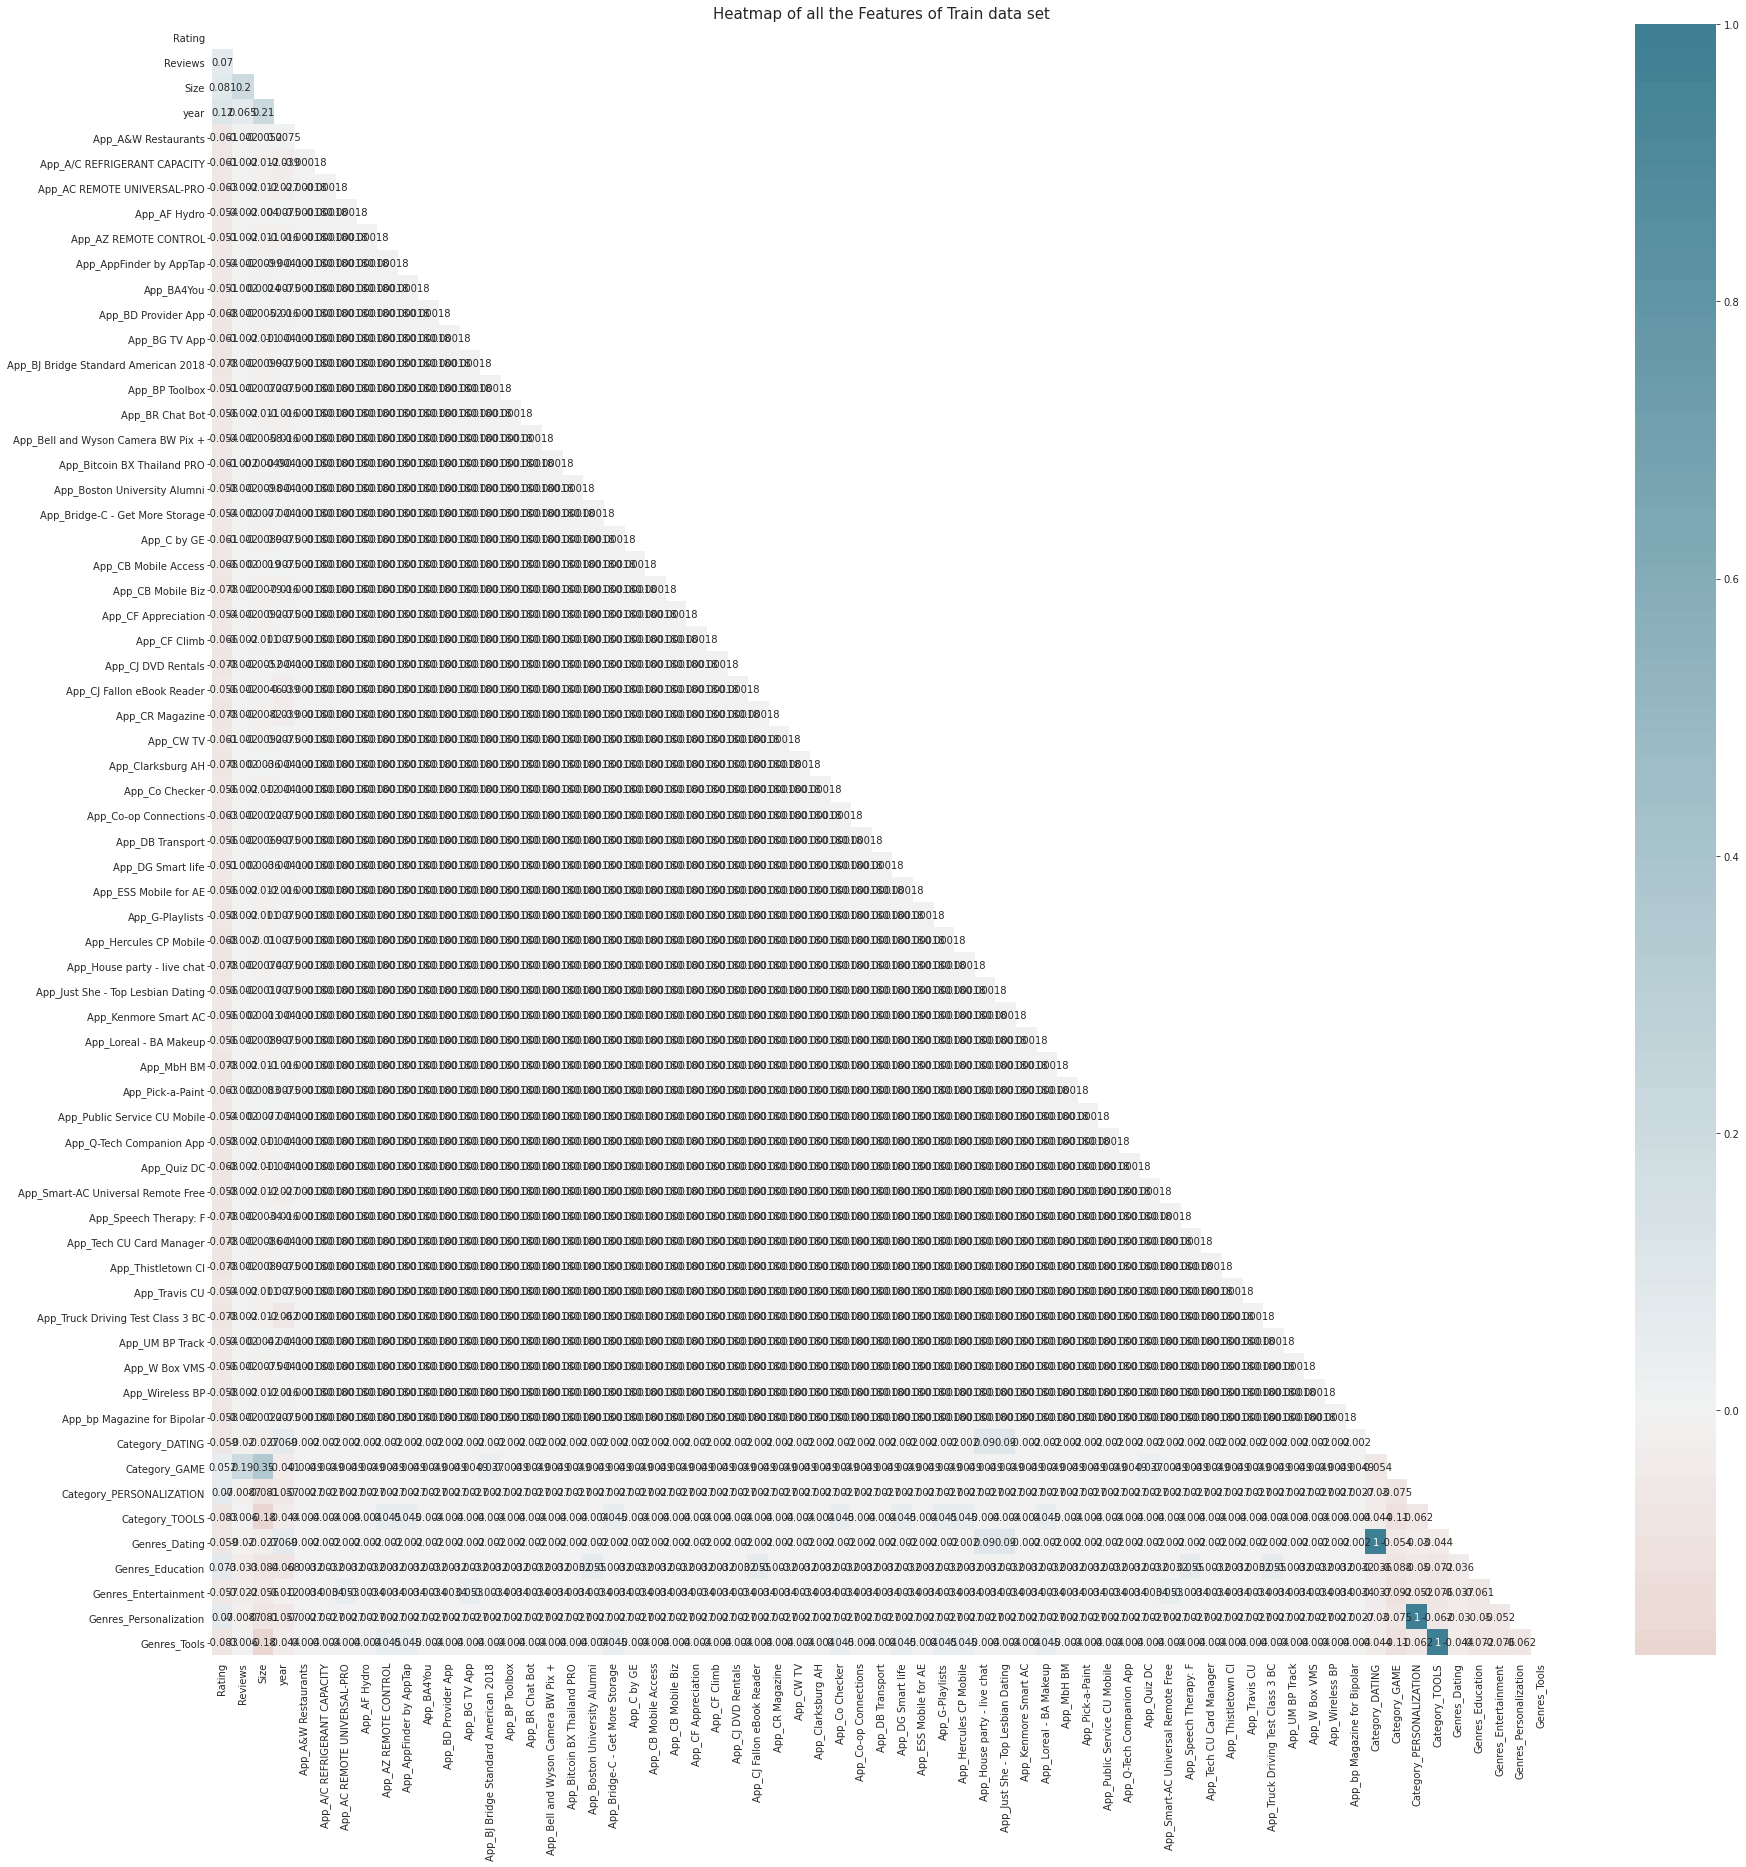

In [ ]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,30))
mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 15);

In [ ]:
train_data = X.drop(['Category_TOOLS', 'Category_PERSONALIZATION', 'Category_DATING'],axis=1)

# 2.Modeling



In [ ]:
! pip install vecstack
! pip install lightgbm
! pip install xgboost

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB     
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder

In [ ]:
lab_enc = LabelEncoder()
cols = train_data.columns
for col in cols:
    train_data[col] = lab_enc.fit_transform(train_data[col])
X = train_data.drop('Rating', axis=1)
y = train_data['Rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state=318)

In [ ]:
def rmse(y,y_pred):
  return np.sqrt(mean_squared_error(y,y_pred))

def rmse_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
  rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
  return (rmse)

n_folds = 5
train = X

## 2-1. Baseline hyper-parameter tuning

모델들이 독립적으로는 최대 어느 정도의 성능을 내는지 확인해보았다. 

In [ ]:
rf = make_pipeline(RandomForestRegressor())
score = rmse_cv(rf)     
print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random Forest score: 5.6300 (0.2134)



In [ ]:
# RandomForest Classifier

# Grid search
params ={
    "n_estimators" : [100,200,300,400,500],
    "max_features" : [10,20,30,40,50,60]
    }

rf_grid = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, n_jobs=-1)
rf_grid = rf_grid.fit(X_train, y_train)

# best score & params
print("best score: ", rf_grid.best_score_)  
print("best parameters: ", rf_grid.best_params_)

best score:  0.09641373334497286
best parameters:  {'max_features': 50, 'n_estimators': 400}


In [ ]:
rf = RandomForestClassifier(max_features=50, n_estimators=400)
score = rmse_cv(rf)
print("\n Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


 Score: 6.8584 (0.1528)



In [ ]:
#Logistic Regression

# Grid search
params = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['none','l1', 'l2', 'elasticnet']
    }

lr_grid = GridSearchCV(LogisticRegression(), params, cv=list(StratifiedKFold(n_splits=5).split(X_train, y_train))) 
lr_grid.fit(X_train, y_train)

# best score & params
print("best score: ", lr_grid.best_score_)  
print("best parameters: ", lr_grid.best_params_)

best score:  0.1287231118913903
best parameters:  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
# Decision Tree

# Grid search
params = {
    'max_depth' : [2,3,4,5,6,7,8,9,10,11,12], 
    "max_features" : [0,10,20,30,40,50,60],
         }

dt_grid= GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
dt_grid.fit(X_train, y_train)

# best score & params
print("best score: ", dt_grid.best_score_)  
print("best parameters: ", dt_grid.best_params_)


In [ ]:
dt = DecisionTreeClassifier(max_depth=, max_features=)
score = rmse_cv(dt)
print("\n Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
# Naive Bayes Classifier

# Grid search
params = {'var_smoothing': np.logspace(0,-9, 100)}

nb_grid= GridSearchCV(GaussianNB(), param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
nb_grid.fit(X_train, y_train)

# best score & params
print("best score: ", nb_grid.best_score_)  
print("best parameters: ", nb_grid.best_params_)


In [ ]:
nb = GaussianNB()
score = rmse_cv(nb)
print("\n Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
# KNN Classifier

# Grid search
params = {
    'p'=np.array([1,2,3,4,5]),
    'n_neighbors'=np.arange(1,20)
}

knn_grid= GridSearchCV(KNeighborsClassifier(), param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
knn_grid.fit(X_train, y_train)

# best score & params
print("best score: ", knn_grid.best_score_)  
print("best parameters: ", knn_grid.best_params_)


In [ ]:
knn = KNeighborsClassifier()
score = rmse_cv(knn)
print("\n Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
#SVM Classifier

# Grid search
params = {
    'C':np.logspace(-2, 8, 5),
    'gamma':np.logspace(-8, -4, 5),
    'kernel': ["rbf", "linear"]
}

svm_grid= GridSearchCV(SVC() , param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
svm_grid.fit(X_train, y_train)

# best score & params
print("best score: ", svm_grid.best_score_)  
print("best parameters: ", svm_grid.best_params_)


In [ ]:
svm = SVC(probability=True, C=, gamma=, kernel=, )  
score = rmse_cv(svm)
print("\n Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


# Grid search
params = {
    'n_estimators':[100,200,300,400,500,1000],
    'kernel': ["rbf", "linear"]
}

ada_grid= GridSearchCV(AdaBoostRegressor(), param_grid=params, cv=5, n_jobs=-1)
ada_grid.fit(X_train, y_train)

# best score & params
print("best score: ", ada_grid.best_score_)  
print("best parameters: ", ada_grid.best_params_)


In [ ]:
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=15), n_estimators=, kernel=)
score = rmse_cv(svm)
print("\n Score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
from xgboost import XGBRegressor
#max_depth를 조정해본 결과, 4가 가장 작음.

xgb = XGBRegressor()

params = {
    'n_estimators':[100,200,300,400,500,1000], 
    'max_depth'=[2,4,6,8,10,13]
}
xgb_grid= GridSearchCV(xgb, param_grid=params, cv=5, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# best score & params
print("best score: ", xgb_grid.best_score_)  
print("best parameters: ", xgb_grid.best_params_)

#예측
y_pred= xgb_grid.predict(X_test)
#예측값과 실제값의 차이제곱의 평균 -> RMSE
print("RMSE",rmse_cv(y_test,y_pred))

In [ ]:
import lightgbm 
model_lightgbm = lightgbm.LGBMRegressor(num_leaves=2)
model.fit(X_train, y_train)

## 2-2. Stacking

위에서 분석한 모델들이 stacking되어 하나의 모델을 이루었을 때, 최대 어느 정도의 성능을 내는지 확인해보았다. 

### 1) Basic Stacking

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X_train, y_train):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X_test):
        predictions = np.column_stack([
            model.predict(X_test) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
averaged_models = AveragingModels(models = (dt, svm, lgb, knn))

score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
#좋은 모델 다 때려 넣기
estimator1 = XGBRegressor(n_estimators=120, max_depth=10, learning_rate=0.1, nthread=7)
estimator2 =lightgbm.LGBMRegressor(max_depth=2, learning_rate=0.5, n_estimators=50, n_jobs=-1)
estimator3 = RandomForestRegressor(n_estimators=100, max_features=124, n_jobs=-1, oob_score=True)
estimator4 = SVR(kernel="rbf",C=10,gamma=0.5)
estimator5 = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

base_estimators = [estimator1, estimator2, estimator3, estimator4, estimator5]

for estimator in base_estimators:
            estimator.fit(x_train, y_train)

### 2) Cross Validation Stacking